In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import struct
import seaborn as sns

### Utitlity Functions

In [ ]:
def dBm2Watt(value):
  return 10 ** ((value - 30) / 10)


${y(x) = 10^{\dfrac{x-30}{10}}}$


In [ ]:
def dB2linear(value):
  return 10 ** (value / 10)  # 10 if watt 20 if volts


${P(x) = 10 \cdot log_{10}(x)}$


In [ ]:
def linear2dB(value):
  return 10 * np.log10(value)


${P_{dBm} = 10 \cdot log_{10}(\dfrac{P_{(W)}}{1W})+30}$


In [ ]:
def watt2dBm(value):
  return 10 * np.log10(value) + 30

$H^*$

In [ ]:
def Hermitian(m):
  # Hermitian matrix
  return np.array(m).T.conj()

In [ ]:
def normalize_channel(W):
  """
  Normalizes given precoding matrix
  """
  return np.linalg.inv(np.diag(np.diag(W @ Hermitian(W)))) @ W


$H^{\dagger}$

In [ ]:
def pseudo_inverse(M, param=0):
  if param == 0:
    return np.linalg.inv(Hermitian(M) @ M) @ Hermitian(M)
  if param != 0:
    noise = np.random.normal(0, param ** 2, size=(M.shape[0] * 2)).view(np.complex128)
    result = np.correlate(noise, noise, mode='valid')
    return np.linalg.inv(Hermitian(M) @ M + (np.eye(M.shape[1]) * result) ) @ Hermitian(M)


Complex noise



In [ ]:
def noise(shape, rate):
  return np.random.normal(0, rate, size=(shape[0],shape[1]*2)).view(np.complex128)

$A = USV^*$

In [ ]:
#2 SVD
def SVD(H):
  return np.linalg.svd(H)


$c = V \cdot s$

In [ ]:
#3 precoding
def precoding(s, V):
  return V @ s

$r = H \cdot Vs +n $

In [ ]:
#4 recieved signal
def recieved(H, c, rate):
  return H @ c + np.random.normal(0, rate, size=(H.shape[0] * 2)).view(np.complex128)

$y = U^*r = U^*H \cdot Vs +U^*n$

In [ ]:
#5 equalized signal
def equalized(U, r):
  return Hermitian(U) @ r

$y = (HV)^\dagger r = (HV)^\dagger HVs + (HV)^\dagger n$

In [ ]:
#8 zero-forcing 
def zf(HV, r):
  return pseudo_inverse(HV) @ r

$y = [\sigma^2_nI +(HV)^H(HV)]^{-1}(HV)^Hr$

In [ ]:
#11 mmse
def mmse(HV, param, r):
  return pseudo_inverse(HV, param) @ r

$x, y$ - bit arrays, elementwise comparison

In [ ]:
#BER
def BER(x, y):
  counter = 0
  for i in range(len(x)):
    if x[i] != y[i]:
      counter += 1 
  return counter / len(x)

In [ ]:
def float32_bit_pattern(value):
    return sum(b << 8*i for i,b in enumerate(struct.pack('f', value)))

def int_to_binary(value, bits):
    return bin(value).replace('0b', '').rjust(bits, '0')

$a, b$ -  arrays of signals. elementwise comparision

In [ ]:
def iBER(a, b):
    innerBer = 0
    for i in range(a.shape[0]):
        a_int = np.array(list(int_to_binary(int(a[i]), 8)))
        b_int = np.array(list(int_to_binary(int(b[i]), 8)))
        innerBer += BER(a_int, b_int)
    return innerBer / a.shape[0]

int value to tuple of bits 

In [ ]:
def int_to_tuple(a):
  return tuple(map(int, list(int_to_binary(a,4))))

In [ ]:
def spectral_efficiency(singulars,send,sigma):
  return np.sum([np.log(1 + s ** 2 * np.abs(send[i])/(sigma)) for i, s in enumerate(singulars)])

transformation of numbers

In [ ]:
def P2R(radii, angles):
    return radii * np.exp(1j*np.radians(angles))

def R2P(x):
    return abs(x), angle(x)

hardcoded QAM modulation

In [ ]:
qam_modulation = {
    (0,0,0,0) : (1.4142, 135.0000),
    (0,0,0,1) : (1.1180, 116.5650),
    (0,0,1,0) : (1.4142,  45.0000),
    (0,0,1,1) : (1.1180,  63.4350),
    (0,1,0,0) : (1.4142, 225.0000),
    (0,1,0,1) : (1.1180, 243.4350),
    (0,1,1,0) : (1.4142, 315.0000),
    (0,1,1,1) : (1.1180, 296.5650),
    (1,0,0,0) : (1.1180, 153.4350),
    (1,0,0,1) : (0.7071, 135.0000),
    (1,0,1,0) : (1.1180,  26.5650),
    (1,0,1,1) : (0.7071,  45.0000),
    (1,1,0,0) : (1.1180, 206.5650),
    (1,1,0,1) : (0.7071, 225.0000),
    (1,1,1,0) : (1.1180, 333.4350),
    (1,1,1,1) : (0.7071, 315.0000)
}

int value to QAM as complex number

In [ ]:
def int_to_qam_complex(a):
  return P2R(*qam_modulation[int_to_tuple(a)])

In [ ]:
def intarr_to_qam_complexarr(ar):
  comp = [0]*len(ar)
  for i, el in enumerate(ar):
    comp[i] = int_to_qam_complex(el)
  return comp

In [ ]:
def qam_ml_decoder(c):
  closest = ()
  min_distance = np.Infinity
  for bits, position in qam_modulation.items():
    distance = np.linalg.norm(c-P2R(*position))
    if distance < np.abs(min_distance):
      closest = bits
      min_distance = distance
  return closest

In [ ]:
def cBER(a,b):
  innerBer = 0
  for i,a_item in enumerate(a):
    innerBer += BER(qam_ml_decoder(a[i]),qam_ml_decoder(b[i]))
  return innerBer/len(a)

In [ ]:
SNRs = np.linspace(0, 20, 20)
SNR = SNRs[5]
rate = 1 / (dB2linear(SNR))
print(rate)

0.29763514416313186


### Modeling

#### 4x4  and 4x6 MIMO methods comparison

999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000


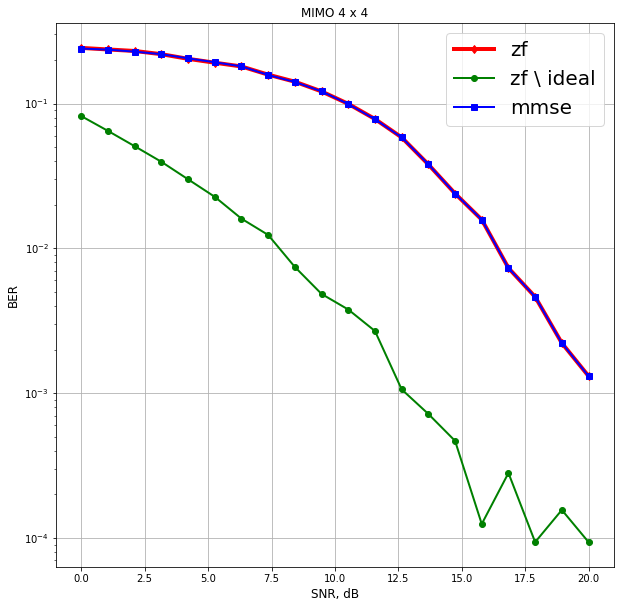

999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000


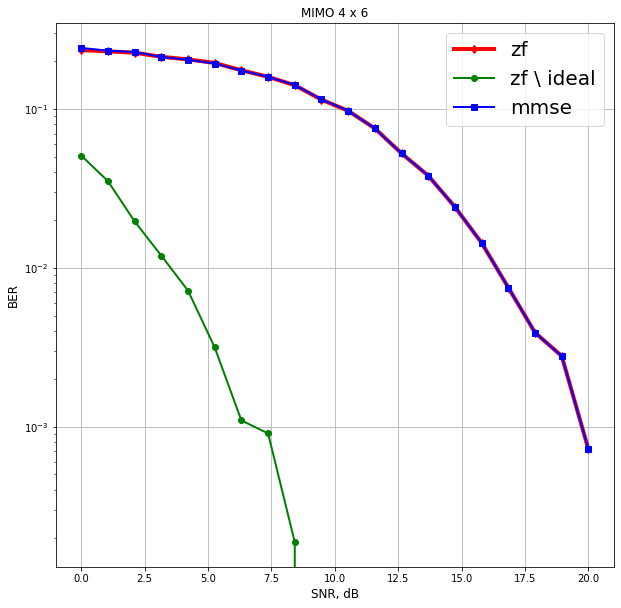

In [ ]:
configs = [(4, 4), (4, 6)]
SNRs = np.linspace(0, 20, 20)
num_iters = int(1e3)

for MIMO_config in configs:

  tx = MIMO_config[0]
  rx = MIMO_config[1]

  ber_eq_ar = []
  ber_zf_ar = []
  ber_zf_ideal_ar = []
  ber_mmse_ar = []

  # s = np.array([
  #     np.complex(1 / np.sqrt(2), 1 / np.sqrt(2)),
  #     np.complex(1 / np.sqrt(2), -1 / np.sqrt(2)),
  #     np.complex(-1 / np.sqrt(2), 1 / np.sqrt(2)),
  #     np.complex(-1 / np.sqrt(2), -1 / np.sqrt(2))
  # ])

  for SNR in SNRs:

      rate = 1 / (dB2linear(SNR))
      sigma = rate 
      
      ber_eq = 0
      ber_zf = 0
      ber_zf_ideal = 0
      ber_mmse = 0


      for i in range(num_iters):
          #channel matrix H and H~
          H = np.random.normal(0, 1, size=(rx, tx * 2)).view(np.complex128)
          H_hat = H + noise(H.shape, sigma)

          U, D, V = SVD(H)
          V = Hermitian(V)

          U_hat, D_hat, V_hat = SVD(H_hat)
          V_hat = Hermitian(V_hat)

          # Generate signal
          s = np.random.randint(16, size=(tx))
          # s = intarr_to_qam_complexarr(s)

          c_hat = precoding(s, V_hat)  # c~ = V~s
          c = precoding(s, V)         # c = Vs

          # recieved signal
          r_hat = recieved(H, c_hat, sigma)  # r~ = H V~s + n
          r = recieved(H, c, sigma)  # r = H Vs + n

          # equalized
          y1 = equalized(U, r_hat)  # y = U^* r = U^* U D V^* V~s + U^* n = D V^* V~s + U^* n

          # decoded zero forcing
          y2_hat = zf(H @ V, r_hat)  # y = (H~V~)^dagger r~ = V*V~s + (U~D~)^-1 n
          y2 = zf(H @ V, r)  # y = (HV)^dagger r = s + (HV)^-1 n

          # decoded mmse
          y3 = mmse(H @ V, sigma, r_hat)  # y = (nI + HV)^dagger r~

          # calculate BER here
          # ber_eq += iBER(np.rint(s * D), (np.rint(np.abs(y1))))
          
          ber_zf += iBER(s, (np.rint(np.abs(y2_hat))))
          ber_zf_ideal += iBER(s, (np.rint(np.abs(y2))))
          ber_mmse += iBER(s, (np.rint(np.abs(y3))))
          
          # ber_zf += cBER(s, y2_hat)
          # ber_zf_ideal += cBER(s, y2)
          # ber_mmse += cBER(s, y3)

          print(f'{i}/{num_iters}', end='\r')

      print()

      # ber_eq_ar.append(ber_eq / num_iters)
      ber_zf_ar.append(ber_zf / num_iters)
      ber_zf_ideal_ar.append(ber_zf_ideal / num_iters)
      ber_mmse_ar.append(ber_mmse / num_iters)

  plt.figure(figsize=(10, 10))
  # plt.plot(SNRs, ber_eq_ar, '-<k', label='svd', linewidth=2)
  plt.plot(SNRs, ber_zf_ar, '-dr', label='zf', linewidth=4)
  plt.plot(SNRs, ber_zf_ideal_ar, '-og', label='zf \ ideal', linewidth=2)
  plt.plot(SNRs, ber_mmse_ar, '-sb', label='mmse', linewidth=2)
  plt.legend(fontsize=20)
  plt.xlabel('SNR, dB', fontsize=12)
  plt.ylabel('BER', fontsize=12)
  plt.yscale('log')
  plt.title(f'MIMO {tx} x {rx}')
  plt.grid()
  plt.show()




999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000


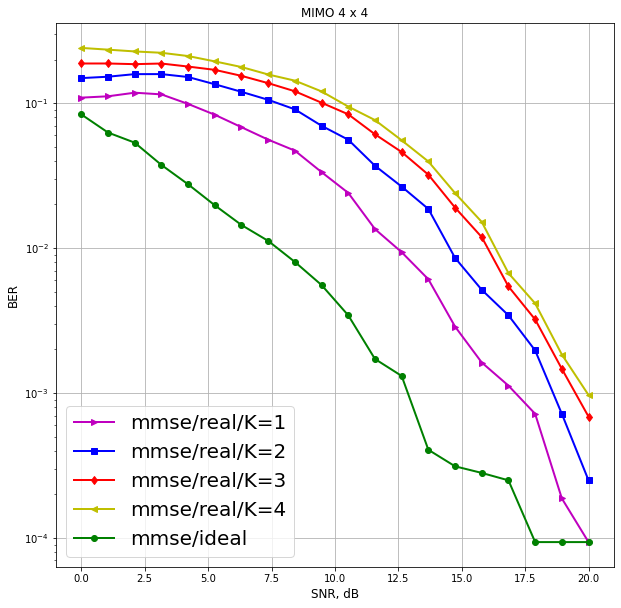

999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000
999/1000


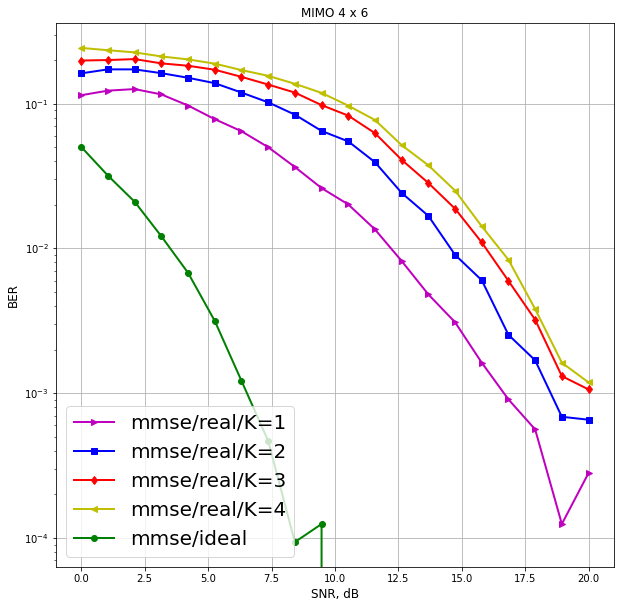

In [ ]:
# comparasion of eigenmods
configs = [(4, 4), (4, 6)]
SNRs = np.linspace(0, 20, 20)
num_iters = int(1e3)

for MIMO_config in configs:

  tx = MIMO_config[0]
  rx = MIMO_config[1]

  ber_mmse_1_ar = []
  ber_mmse_2_ar = []
  ber_mmse_3_ar = []
  ber_mmse_4_ar = []
  ber_mmse_ideal_ar = []



  s = np.random.randint(2, size=(tx))

  for SNR in SNRs:
      # print(f"SNR: {SNR}")
      rate = 1 / (dB2linear(SNR))
      sigma = rate #np.sqrt(rate)
      # print(rate)
      ber_mmse_1 = 0
      ber_mmse_2 = 0
      ber_mmse_3 = 0
      ber_mmse_4 = 0
      ber_mmse_ideal = 0


      for i in range(num_iters):
          H = np.random.normal(0, 1, size=(rx, tx * 2)).view(np.complex128)
          H_hat = H + noise(H.shape, sigma)

          U, D, V = SVD(H)
          V = Hermitian(V)

          U_hat, D_hat, V_hat = SVD(H_hat)
          V_hat = Hermitian(V_hat)

          # Generate signal
          s = np.random.randint(16, size=(tx))
          s4 = s.copy()
          s3 = s4.copy()
          s3[3] = 0
          s2 = s4.copy()
          s2[2:] = [0, 0]
          s1 = s4.copy()
          s1[1:] = [0, 0, 0]

          # print(f'generated: {s}')
          c_hat_4 = precoding(s4, V_hat)
          c_hat_3 = precoding(s3, V_hat)
          c_hat_2 = precoding(s2, V_hat)
          c_hat_1 = precoding(s1, V_hat)
          c = precoding(s, V)

          # recieved signal
          r_hat_4 = recieved(H, c_hat_4, sigma)
          r_hat_3 = recieved(H, c_hat_3, sigma)
          r_hat_2 = recieved(H, c_hat_2, sigma)
          r_hat_1 = recieved(H, c_hat_1, sigma)
          r = recieved(H, c, sigma)

          # decoded mmse
          y4 = mmse(H @ V, sigma, r_hat_4)
          y3 = mmse(H @ V, sigma, r_hat_3)
          y2 = mmse(H @ V, sigma, r_hat_2)
          y1 = mmse(H @ V, sigma, r_hat_1)
          y = mmse(H @ V, 0, r)

          # calculate BER here
          ber_mmse_1 += iBER(s1, (np.rint(np.abs(y1))))
          ber_mmse_2 += iBER(s2, (np.rint(np.abs(y2))))
          ber_mmse_3 += iBER(s3, (np.rint(np.abs(y3))))
          ber_mmse_4 += iBER(s4, (np.rint(np.abs(y4))))
          ber_mmse_ideal += iBER(s, (np.rint(np.abs(y))))

          print(f'{i}/{num_iters}', end='\r')

      print()

      ber_mmse_1_ar.append(ber_mmse_1 / num_iters)
      ber_mmse_2_ar.append(ber_mmse_2 / num_iters)
      ber_mmse_3_ar.append(ber_mmse_3 / num_iters)
      ber_mmse_4_ar.append(ber_mmse_4 / num_iters)
      ber_mmse_ideal_ar.append(ber_mmse_ideal / num_iters)
  
  plt.figure(figsize=(10, 10))
  plt.plot(SNRs, ber_mmse_1_ar, '->m', label='mmse/real/K=1', linewidth=2)
  plt.plot(SNRs, ber_mmse_2_ar, '-bs', label='mmse/real/K=2', linewidth=2)
  plt.plot(SNRs, ber_mmse_3_ar, '-dr', label='mmse/real/K=3', linewidth=2)
  plt.plot(SNRs, ber_mmse_4_ar, '-<y', label='mmse/real/K=4', linewidth=2)
  plt.plot(SNRs, ber_mmse_ideal_ar, '-og', label='mmse/ideal', linewidth=2)
  plt.legend(fontsize=20)
  plt.xlabel('SNR, dB', fontsize=12)
  plt.ylabel('BER', fontsize=12)
  plt.yscale('log')
  plt.title(f'MIMO {tx} x {rx}')
  plt.grid()
  plt.show()

### Calculating Spectral efficiency with arrays

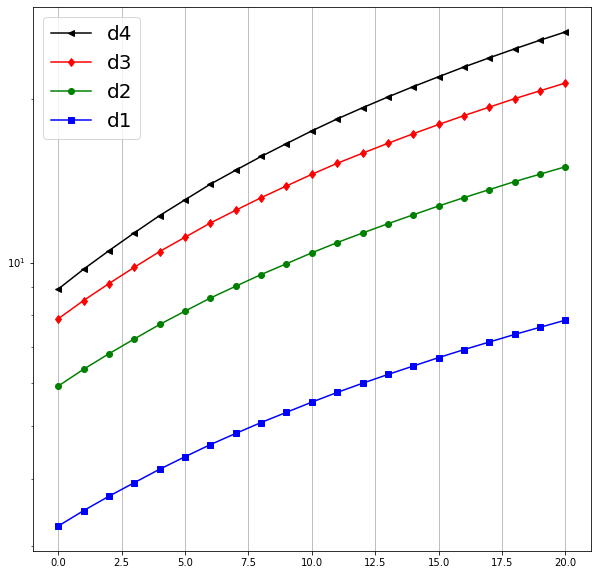

In [ ]:
SNRs = np.linspace(0, 20,21)
s = np.ones(shape=(tx))
d4_e_ar = []
d3_e_ar = []
d2_e_ar = []
d1_e_ar = []
num_iters = int(1e4)
for SNR in SNRs:
  rate = 1/dB2linear(SNR)
  d4_e = 0
  d3_e = 0
  d2_e = 0
  d1_e = 0

  for i in range(num_iters):
    H = np.random.normal(0,1, size=(rx,tx*2)).view(np.complex128)
    U, D, V = SVD(H) 
    d4 = D.copy()
    d3 = d4.copy()
    d3[3] = 0
    d2 = d4.copy()
    d2[2:] = [0, 0]
    d1 = d4.copy()
    d1[1:] = [0, 0, 0]

    # print(spectral_efficiency(d1,s,rate))

    d4_e += spectral_efficiency(d4,s,rate)
    d3_e += spectral_efficiency(d3,s,rate)
    d2_e += spectral_efficiency(d2,s,rate)
    d1_e += spectral_efficiency(d1,s,rate)
    print(f'{i}/{num_iters}', end='\r')
      
  d4_e_ar.append(d4_e / num_iters)
  d3_e_ar.append(d3_e / num_iters)
  d2_e_ar.append(d2_e / num_iters)
  d1_e_ar.append(d1_e / num_iters)

plt.figure(figsize=(10, 10))
plt.plot(SNRs, d4_e_ar, '-<k', label='d4')
plt.plot(SNRs, d3_e_ar, '-dr', label='d3')
plt.plot(SNRs, d2_e_ar, '-og', label='d2')
plt.plot(SNRs, d1_e_ar, '-sb', label='d1')
plt.legend(fontsize=20)
plt.grid(b=True, axis='x')
plt.yscale('log')
plt.show()

In [ ]:
d3_e_ar

### Calculating spectral efficiency from single number

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


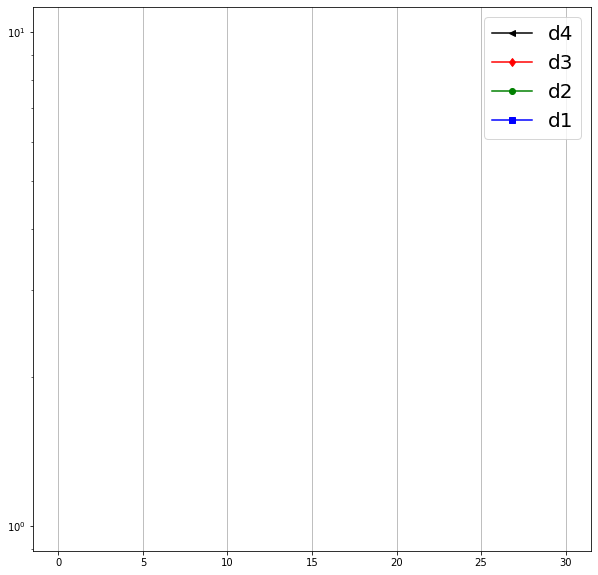

In [ ]:
SNRs = np.linspace(0, 30,31)
s = np.random.randint(2, size=(tx))
d4_e_ar = []
d3_e_ar = []
d2_e_ar = []
d1_e_ar = []
num_iters = int(1e4)
for SNR in SNRs:
  rate = 1/dB2linear(SNR)
  d4_e = 0
  d3_e = 0
  d2_e = 0
  d1_e = 0

  for i in range(num_iters):
    H = np.random.normal(0,1, size=(rx,tx*2)).view(np.complex128)
    U, D, V = SVD(H) 
    d4 = [D[3]]
    d3 = [D[2]]
    d2 = [D[1]]
    d1 = [D[0]]

    d4_e += spectral_efficiency(d4,s,rate)
    d3_e += spectral_efficiency(d3,s,rate)
    d2_e += spectral_efficiency(d2,s,rate)
    d1_e += spectral_efficiency(d1,s,rate)
    print(f'{i}/{num_iters}', end='\r')
      
  d4_e_ar.append(d4_e / num_iters)
  d3_e_ar.append(d3_e / num_iters)
  d2_e_ar.append(d2_e / num_iters)
  d1_e_ar.append(d1_e / num_iters)

plt.figure(figsize=(10, 10))
plt.plot(SNRs, d4_e_ar, '-<k', label='d4')
plt.plot(SNRs, d3_e_ar, '-dr', label='d3')
plt.plot(SNRs, d2_e_ar, '-og', label='d2')
plt.plot(SNRs, d1_e_ar, '-sb', label='d1')
plt.legend(fontsize=20)
plt.grid(b=True, axis='x')
plt.yscale('log')
plt.show()

In [ ]:
ber_eq_ar[:5]

$H = UDV^H$

$c = V \cdot s$

$r = H \cdot Vs +n $

$y = Y^Hr = U^HH \cdot Vs +U^Hn = U^HUDV^H \cdot Vs + U^Hn$

$y = Ds + U^Hn$

$y_i = d_i \cdot s_i + n_i$

$SNR_i = d_i^2 \cdot \dfrac{|s_i|^2}{2\sigma^2_n}$

$y = (HV)^\dagger r = (HV)^\dagger HVs + (HV)^\dagger n$

$ y = s + (UD)^{-1}n$

$\text{Error} = \text{min}(\mathbb{E} \{||s\hat - s ||^2_2\})$

$y = [\sigma^2_nI +(HV)^H(HV)]^{-1}(HV)^Hr$

$\tilde H = H + N$

$\tilde H = \tilde U \tilde D \tilde V^H$

$\tilde c = \tilde V s$

$y = DV^H \tilde V \cdot s + U^Hn$

$NPR = \dfrac {SNR_{CSI}} {SNR_{rec.}} = \dfrac {\sigma_n^2} {\sigma^2/N}$

### singular values distribution

In [ ]:
def plotting_dist_singular_values(SNR, num_iters):
    MIMO_config = (4, 4)
    iterations_num = 1
    tx = MIMO_config[0]
    rx = MIMO_config[1]

    num_iters = int(1e4)

    ber_eq_ar = []
    ber_zf_ar = []
    ber_zf_ideal_ar = []
    ber_mmse_ar = []

    s = np.array([
    np.complex(1 / np.sqrt(2), 1 / np.sqrt(2)),
    np.complex(1 / np.sqrt(2), -1 / np.sqrt(2)),
    np.complex(-1 / np.sqrt(2), 1 / np.sqrt(2)),
    np.complex(-1 / np.sqrt(2), -1 / np.sqrt(2))
    ])

    s = np.random.randint(2, size=(tx))

    rate = 1 / (dB2linear(SNR))
    sigma = rate
    ber_eq = 0
    ber_zf = 0
    ber_zf_ideal = 0
    ber_mmse = 0

    ideal_channel_sin = np.zeros((4, num_iters))
    real_channel_sin = np.zeros((4, num_iters))
    for i in range(num_iters):
        H = np.random.normal(0, 1, size=(rx, tx * 2)).view(np.complex128)
        H_hat = H + noise(H.shape, sigma)

        U, D, V = SVD(H)
        V = Hermitian(V)
        ideal_channel_sin[:,i] = D

        U_hat, D_hat, V_hat = SVD(H_hat)
        V_hat = Hermitian(V_hat)
        real_channel_sin[:,i] = D_hat
    return ideal_channel_sin, real_channel_sin

In [ ]:
num_iters = 1e5

arr1, arr2 = plotting_dist_singular_values(5, num_iters)

Text(0, 0.5, '$p(d)_k$')

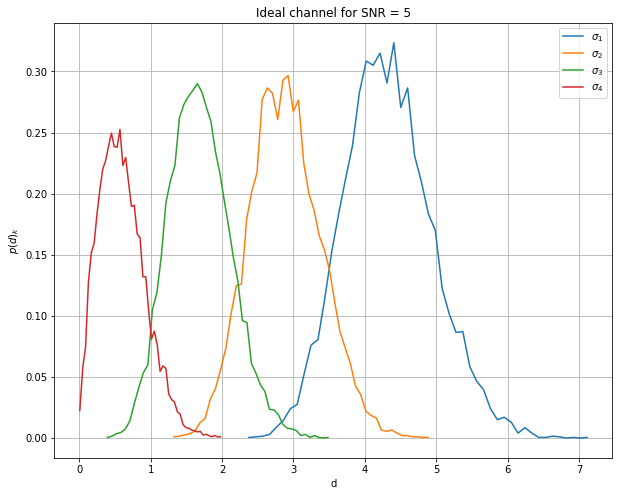

In [ ]:
number_of_bins = 50
plt.figure(figsize=(10, 8))
for i in range(4):
    hist, bin_edges = np.histogram(arr1[i, :], bins=number_of_bins)
    hist = hist* number_of_bins/num_iters
    plt.plot(bin_edges[:-1], hist, label="$\sigma_" + str(i+1)+"$")

plt.legend()
plt.grid()
plt.title('Ideal channel for SNR = 5')
plt.xlabel('d')
plt.ylabel('$p(d)_k$')

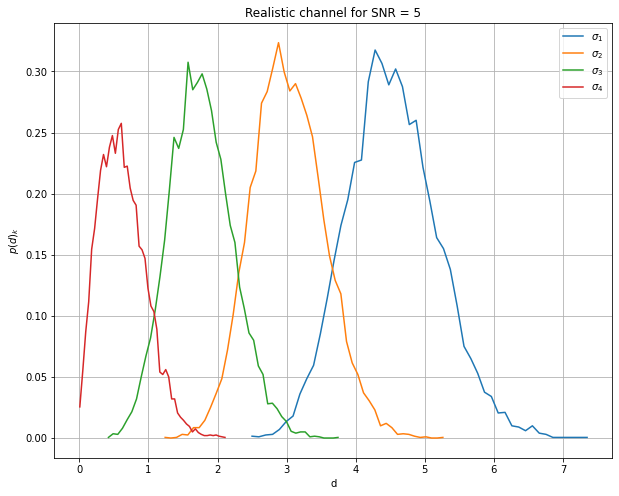

In [ ]:
number_of_bins = 50
plt.figure(figsize=(10,8))
for i in range(4):
    hist, bin_edges = np.histogram(arr2[i, :], bins=number_of_bins)
    hist = hist * number_of_bins/num_iters
    plt.plot(bin_edges[:-1], hist, label="$\sigma_" + str(i+1)+"$")
plt.legend()
plt.grid();
plt.title('Realistic channel for SNR = 5');
plt.xlabel('d')
plt.ylabel('$p(d)_k$');

### QAM modeling

In [ ]:
P2R(*qam_modulation[(0,0,1,1)])
# np.linalg.norm(c-P2R(*qam_modulation[(0,0,1,0)]))

In [ ]:
qam_ml_decoder(np.complex(1/np.sqrt(2),1/np.sqrt(2)))

In [ ]:
qam_ml_decoder(np.complex(1/np.sqrt(2),-1/np.sqrt(2)))

In [ ]:
qam_ml_decoder(np.complex(-1/np.sqrt(2),-1/np.sqrt(2)))

In [ ]:
qam_ml_decoder(np.complex(-1/np.sqrt(2),1/np.sqrt(2)))

In [ ]:
import time

In [ ]:
# 4x4 comparasion

MIMO_config = (4, 4)
SNRs = np.linspace(0, 20, 21)
tx = MIMO_config[0]
rx = MIMO_config[1]
num_iters = int(1e4)

ber_eq_ar = []
ber_zf_ar = []
ber_zf_ideal_ar = []
ber_mmse_ar = []

s = np.array([
    np.complex(1 / np.sqrt(2), 1 / np.sqrt(2)),
    np.complex(1 / np.sqrt(2), -1 / np.sqrt(2)),
    np.complex(-1 / np.sqrt(2), 1 / np.sqrt(2)),
    np.complex(-1 / np.sqrt(2), -1 / np.sqrt(2))
])


for SNR in SNRs:
    rate = 1 / (dB2linear(SNR))
    sigma = rate #np.sqrt(rate)
    ber_eq = 0
    ber_zf = 0
    ber_zf_ideal = 0
    ber_mmse = 0

    cur_time = time.time()
    for i in range(num_iters):
        H = np.random.normal(0, 1, size=(rx, tx * 2)).view(np.complex128)
        H_hat = H + noise(H.shape, sigma)


        # Generate signal
        # s = np.random.randint(0,16, size=(tx))
        # s = map(int_to_qam_complex, s)
        U, D, V = SVD(H)
        V = Hermitian(V)

        U_hat, D_hat, V_hat = SVD(H_hat)
        V_hat = Hermitian(V_hat)

        # print(D)
        # print(D_hat)
        D_mat = np.diag(D)



        # print(f'generated: {s}')
        c_hat = precoding(s, V_hat)  # c~ = V~s
        c = precoding(s, V)

        # recieved signal
        r_hat = recieved(H, c_hat, sigma)  # r~ = H~ V~s + n
        r = recieved(H, c, sigma)  # r = H V~s + n

        # equalized
        y1 = equalized(U, r_hat)  # y = U^H r = U^H U D V^H V~s + U^H n = D V^H V~s + U^H n

        # decoded zero forcing
        y2_hat = zf(H @ V, r_hat)  # y = (H~V~)^dagger r~ = s + (U~D~)^-1 n
        y2 = zf(H @ V, r)  # y = (HV)^dagger r = (HV)^dagger

        # decoded mmse
        y3 = mmse(H @ V, sigma, r_hat)  # y = (nI + HV)^dagger r~

        # calculate BER here
        # ber_eq += cBER(s * D, y1)
        ber_zf += cBER(s, y2_hat)
        ber_zf_ideal += cBER(s, y2)
        ber_mmse += cBER(s, y3)

        print(f'{i}/{num_iters}', end='\r')

    print(f'elapsed time: {time.time() - cur_time}')

    ber_eq_ar.append(ber_eq / num_iters)
    ber_zf_ar.append(ber_zf / num_iters)
    ber_zf_ideal_ar.append(ber_zf_ideal / num_iters)
    ber_mmse_ar.append(ber_mmse / num_iters)

plt.figure(figsize=(10, 10))
# plt.plot(SNRs, ber_eq_ar, '-<k', label='svd', linewidth=2)
plt.plot(SNRs, ber_zf_ar, '-dr', label='zf', linewidth=4)
plt.plot(SNRs, ber_zf_ideal_ar, '-og', label='zf \ ideal', linewidth=2)
plt.plot(SNRs, ber_mmse_ar, '-sb', label='mmse', linewidth=2)
plt.legend(fontsize=20)
plt.xlabel('SNR, dB', fontsize=12)
plt.ylabel('BER', fontsize=12)
plt.yscale('log')
plt.show()

In [ ]:
cBER(s,y3)

In [ ]:
s

In [ ]:
y3

In [ ]:
list(s)

In [ ]:
def cBER(a,b):
  innerBer = 0
  for i,a_item in enumerate(a):
    innerBer += BER(np.array(list(int_to_binary(a[i], 4))),qam_ml_decoder(b[i]))
  return innerBer/len(a)